In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import FGA
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from tqdm import tqdm
import argparse
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import random # for random choice of nodes
import logging # for logging file

In [ ]:
################################ split adjacency matrixes and find nodes which have changes##########################
# Set up seeds
seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Set up logging
logging.basicConfig(filename='results.log', filemode='w', level=logging.INFO, format='%(message)s')
logger = logging.getLogger()


################################ Data loading- features-test #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn')
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

#############################  preprocessing ############################
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

# print ("adj shape: ", adj.shape)
# print ("features shape: ", features.shape)
# print ("labels shape: ", labels.shape)  
# print (features)


# Split graph into two subgraphs for Crypto'Graph: by randomly removing some edges.but the nodes are the same
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

print ("adj1 shape: ", adj1.shape)
print ("adj2 shape: ", adj2.shape)


# Assuming adj1 and adj2 are your adjacency matrices
# Step 1: Check dimensions
if adj1.shape != adj2.shape:
    print("Matrices have different dimensions.")
else:
    # Step 2: Find differences
    differences = np.abs(adj1 - adj2)
    
    # Step 3: Count differences
    total_differences = np.sum(differences)
    print(f"Total number of differences: {total_differences}")
    
    # Count non-zero differences (i.e., actual changes)
    # changes = np.count_nonzero(differences)
    # print(f"Number of elements that differ: {changes}")
    
    # Step 4: Count rows
    rows = adj1.shape[0]
    print(f"adj1. Number of rows: {rows}")
    rows_adj2= adj2.shape[0]
    print(f"adj2. Number of rows: {rows_adj2}")

    # Identify rows with changes
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")

    # Print out the specific rows with changes
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")
    # f.write(f"Rows with different connectivities: {changed_rows}\n")



In [ ]:
####### Visualization of the adjacency matrix and check if it is weighted or not
adj1_dense = adj1.toarray()
# print(adj1_dense)

plt.imshow(adj1_dense, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

adj2_dense = adj2.toarray()
plt.imshow(adj2_dense, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Print the first 10x10 submatrix of the adjacency matrix
print(adj1_dense[:10, :10])
print(adj2_dense[:10, :10])

# Check if the adjacency matrix is weighted or not
def is_weighted(adj_matrix):
    # Flatten the matrix to a 1D array for easy iteration
    flat_matrix = adj_matrix.flatten()
    # Check if all values are 0 or 1
    return not np.all(np.logical_or(flat_matrix == 0, flat_matrix == 1))
print("The adj1 is weighted:", is_weighted(adj1_dense))
print("The adj2 is weighted:", is_weighted(adj2_dense))



In [ ]:
#### check only main adj matrix################

node_id = 4
adj_dense = adj.toarray()
# adj2_dense = adj2.toarray()
row_adj = adj_dense[node_id, :]  # Get the row for node_id from adj1
# row_adj2 = adj2_dense[node_id, :]  # Get the row for node_id from adj2

print(f"Node {node_id} connectivities in adj: {row_adj}")
print(f"Node {node_id} connectivities in adj: {[f'index {i}: value {v}' for i, v in enumerate(row_adj)]}")
print(f"Node {node_id} connectivities in adj with value 1.0: {[f'index {i}: value {v}' for i, v in enumerate(row_adj) if v == 1.0]}")

gr = nx.from_scipy_sparse_array(adj)
print(f"adj is ",gr)

# Directly compare edges for node 0 in both graphs
edges_gr = set(gr.edges(node_id))
print(f"Edges of node {node_id} in gr: {edges_gr}")



In [ ]:
#################################  check the differences between adj1 and adj2 ############################
# Adjust numpy print options to show full arrays
# np.set_printoptions(threshold=np.inf)

node_id = 4
adj1_dense = adj1.toarray()
adj2_dense = adj2.toarray()
row_adj1 = adj1_dense[node_id, :]  # Get the row for node_id from adj1
row_adj2 = adj2_dense[node_id, :]  # Get the row for node_id from adj2

# row_adj1 = adj1[node_id, :].toarray().flatten().tolist()  # Get the row for node_id from adj1
# row_adj2 = adj2[node_id, :].toarray().flatten().tolist()  # Get the row for node_id from adj2
# differences_for_node = row_adj1 != row_adj2
# different_indices = np.where(differences_for_node)[0]  # Indices of differences

differences_for_node = row_adj1 != row_adj2
different_indices = np.where(differences_for_node)[0]

# print(f"Node {node_id} connectivities in adj1: {row_adj1}")
print(f"Node {node_id} connectivities in adj1: {[f'index {i}: value {v}' for i, v in enumerate(row_adj1)]}")
# print(f"Node {node_id} connectivities in adj2: {row_adj2}")
print(f"Node {node_id} connectivities in adj2: {[f'index {i}: value {v}' for i, v in enumerate(row_adj2)]}")
print(f"Differences for node {node_id}: {differences_for_node}")
print(f"Indices with differences for node {node_id}: {different_indices}")
print(f"only differences for node {node_id} in adj1: {[f'index {i}: value {v}' for i, v in enumerate(row_adj1) if differences_for_node[i]]}")
print(f"only differences for node {node_id} in adj2: {[f'index {i}: value {v}' for i, v in enumerate(row_adj2) if differences_for_node[i]]}")


print(f"Node {node_id} connectivities in adj1 with value 1.0: {[f'index {i}: value {v}' for i, v in enumerate(row_adj1) if v == 1.0]}")
print(f"Node {node_id} connectivities in adj2 with value 1.0: {[f'index {i}: value {v}' for i, v in enumerate(row_adj2) if v == 1.0]}")

# logger.info(f"Total number of differences: {total_differences}")
# logger.info("Node %s connectivities in adj1: %s", node_id, row_adj1)
# logger.info("Node %s connectivities in adj2: %s", node_id, row_adj2)
# logger.info("Differences for node %s: %s", node_id, differences_for_node)
# logger.info("Indices with differences for node %s: %s", node_id, np.where(differences_for_node)[0])


# Ensure adj1 and adj2 are in sparse format
adj1 = sp.csr_matrix(adj1)
adj2 = sp.csr_matrix(adj2)

# Convert adjacency matrices to networkx graphs
gr1 = nx.from_scipy_sparse_array(adj1)
print(f"after convert nx adj1 is ",gr1)
gr2 = nx.from_scipy_sparse_array(adj2)
print(f"after convert nx adj2 is ",gr2)

# Directly compare edges for node 0 in both graphs
edges_gr1 = set(gr1.edges(node_id))
edges_gr2 = set(gr2.edges(node_id))
print(f"Edges of node {node_id} in gr1: {edges_gr1}")
print(f"Edges of node {node_id} in gr2: {edges_gr2}")


# Function to filter out zero-weight edges
def filter_edges_with_weight(graph, node_id):
    return set((u, v) for u, v, d in graph.edges(node_id, data=True) if d.get('weight', 1) > 0)

# Directly compare edges for a specific node
edges_gr1_filtered = filter_edges_with_weight(gr1, node_id)
edges_gr2_filtered = filter_edges_with_weight(gr2, node_id)
print(f"Filtered edges of node {node_id} in gr1: {edges_gr1_filtered}")
print(f"Filtered edges of node {node_id} in gr2: {edges_gr2_filtered}")

edges_gr1 = list(gr1.edges(node_id, data=True))
edges_gr2 = list(gr2.edges(node_id,data=True))
print(f"Edges in gr1: {edges_gr1}")
print(f"Edges in gr2: {edges_gr2}")


# Check for differences
if edges_gr1 != edges_gr2:
    print("Differences found in edges.")
else:
    print("No differences found in edges.")


# Check if gr1 is directed or undirected
if gr1.is_directed():
    print("gr1 is a directed graph.")
else:
    print("gr1 is an undirected graph.")
# Check if gr2 is directed or undirected
if gr2.is_directed():
    print("gr2 is a directed graph.")
else:
    print("gr2 is an undirected graph.")


# Check if adjacency matrices are symmetric - if they are symmentirc graph is undirected 
def is_symmetric(matrix):
    return np.array_equal(matrix, matrix.T)
symmetry_check_adj1 = is_symmetric(adj1_dense)
symmetry_check_adj2 = is_symmetric(adj2_dense)
print(f"adj1 is symmetric: {symmetry_check_adj1}") # true or false
print(f"adj2 is symmetric: {symmetry_check_adj2}")


############## solution
# # Function to remove zero-weight edges from an adjacency matrix
# def remove_zero_weight_edges(adj):
#     adj.data[adj.data == 0] = 0
#     adj.eliminate_zeros()
#     return adj

# Remove zero-weight edges
clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())

# Convert cleaned adjacency matrices to networkx graphs
graph1 = nx.from_scipy_sparse_array(clean_adj1)
graph2 = nx.from_scipy_sparse_array(clean_adj2)


neighbors_gr1 = list(graph1.neighbors(node_id))
print(f"Neighbors of node {node_id} in gr1: {neighbors_gr1}")
neighbors_gr2 = list(graph2.neighbors(node_id))
print(f"Neighbors of node {node_id} in gr2: {neighbors_gr2}")




In [ ]:
################################# V0: adding edges - Attack repeatedly - consider crypto'Graph ###############################
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset , setting='gcn', seed=15)   
# setting='gcn' is for the GCN model, in latest experiments befor 2024-06-11 used default which is nettack
# seed=15 is for the GCN model, in latest experiments befor 2024-06-11 no seeds were used. seed is used to make the results reproducible
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems


for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts randomly
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    #choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])

    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print (f"idx_test_attack",idx_test_attack)
    # print (f"idx_test_clean",idx_test_clean)
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print (idx_train)
    # print ("val",len (idx_val))


# Split graph into two subgraphs for Crypto'Graph: by randomly removing some edges.but the nodes are the same
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    print ("adj1 shape: ", adj1.shape)
    print ("adj2 shape: ", adj2.shape)

    print ("adj shape: ", adj.shape)
    print ("features shape: ", features.shape)
    print ("labels shape: ", labels.shape)
   
    #check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


    # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)

   
    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 0: attack on the whole graph - on idx_test_attack nodes

    modified_adj1 =  clean_adj1.copy()
    # modified_adj1 =  adj2.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)


    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    print("*************** mahsa attack ***************")
    # Set the budget for the attack
    budget = 90

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        non_neighbor_opposit = backdoor.find_non_neighbor_opposit_label(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, non_neighbor_opposit)
        nodes_for_attack = backdoor.nodes_for_attack(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.insert_edge(attacked_graph, target_node, nodes_for_attack)
        backdoor.evaluate_graph(attacked_graph, nodes_for_attack, target_node, budget)
        
    print(attacked_graph)
    print(f"total inserted edges : {attacked_graph.number_of_edges() - graph.number_of_edges()}")

    # check for the differences between the initial graph and the attacked graph----- adj wise
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    # compare graphs check
    initial_edges = graph.number_of_edges()
    attacked_edges = attacked_graph.number_of_edges()
    print(f"graph check : Initial edges: {initial_edges} and attacked edges: {attacked_edges}")
    print(f"graph check: Total inserted edges after attack: {attacked_edges - initial_edges}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors ofter attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors ofter attack and they are: {n2}")

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_2)
    print("Test accuracy on clean set: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), 
                features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_3)
    print("Test accuracy on clean set: ", accuracy_test_clean_3)



    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
   
    
    ################# adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


   
    ################# check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges by CG defense: {removed_edges_by_CG}")
   




    ##################  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)

    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")


    print("*************** graph wise - check if inserted edges are removed ***************")
    # if inserted edges are eremoved or not: NX graphs
    inserted_edges = set(attacked_graph.edges()) - set(graph.edges())
    # Print inserted edges
    print("Inserted edges (node1, node2):")
    for edge in inserted_edges:
        print(edge)
   
    # Check if inserted edges have been deleted by Crypto'Graph defense
    deleted_inserted_edges = inserted_edges - set(graph_CG_1.edges())

    # Print deleted inserted edges
    print("Deleted inserted edges by Crypto'Graph defense (node1, node2):")
    for edge in deleted_inserted_edges:
        print(edge)

    # Total number of deleted inserted edges
    total_deleted_inserted_edges = len(deleted_inserted_edges)
    print(f"Total number of deleted inserted edges: {total_deleted_inserted_edges}")

    ####another ay : 
    # Calculate intersection of inserted and removed edges
    intersected_edges = inserted_edges.intersection(removed_edges_graph)
    # Check if any inserted edge was removed
    if intersected_edges:
        print("Inserted edges that were removed (node1, node2):")
        for edge in intersected_edges:
            print(edge)
    else:
        print("No inserted edges were removed.")
        
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)


In [ ]:
################################# V0 - Plotting ACcuracies #######################################
####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

# print("Average test accuracy on attack set 1: ", accuracy_test_attack_1_avg)
# print("Average test accuracy on clean set 1: ", accuracy_test_clean_1_avg)
# print("Average test accuracy on attack set 2: ", accuracy_test_attack_2_avg)
# print("Average test accuracy on clean set 2: ", accuracy_test_clean_2_avg)
# print("Average test accuracy on attack set 3: ", accuracy_test_attack_3_avg)
# print("Average test accuracy on clean set 3: ", accuracy_test_clean_3_avg)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    
##################################
          
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# # Create the bar chart
# bars1 = plt.bar(x - width/2, values[::2], width, label='Attack set', color='red')
# bars2 = plt.bar(x + width/2, values[1::2], width, label='Clean set', color='blue')

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])

# Add a legend
plt.legend()

# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()

# Display the chart
plt.show()

In [ ]:
################################# Attack one node (adding label) each time to discover node conditions ###############################
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn')
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    #choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 611
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print ("val",len (idx_val))

    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)

    # accuracies = model.test(idx_test) 
    # print("Test accuracy: ", accuracies)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)

    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 0: attack on the whole graph - on idx_test_attack nodes

    modified_adj1 =  adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)

    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    # Set the budget for the attack
    budget = 5

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        non_neighbor_opposit = backdoor.find_non_neighbor_opposit_label(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, non_neighbor_opposit)
        nodes_for_attack = backdoor.nodes_for_attack(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.insert_edge(attacked_graph, target_node, nodes_for_attack)
        backdoor.evaluate_graph(attacked_graph, nodes_for_attack, target_node, budget)
   
    print ( f"idx_test_attack: {idx_test_attack}")
    neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    print ( f"number of target same label neighbors: {len(neighbors_same_label)}")
    print ( f"number of target opposit label neighbors: {len(neighbors_opposit_label)}")
    print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    print ( f"number of target NONE neighbors opposite label: {len(backdoor.find_non_neighbor_opposit_label(graph, selected_node))}")
    print ( f"idx_test_attack opposit label NONE neighbors: {backdoor.find_non_neighbor_opposit_label(graph, selected_node)}")

    ################################## Plotting target node before attack  #######################################
    target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # edges
    nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # labels
    nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    plt.axis('off')
    plt.show()

   
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    print(f"total inserted edges : {(attacked_graph.number_of_edges() - graph.number_of_edges())}")

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results#######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()                

In [ ]:
################################# V1: Attack by removing edges ###############################
################################# V2: Attack by removing edges + consider cummon neighbors for Crypto ###############################

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn' , seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    #split idx_test into two parts : one node for attack and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")

    # choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    
    #split idx_test into two parts randomly
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

#check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


   # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)


    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print(f"idx_test_attack",idx_test_attack)
    # print(f"idx_test_clean",idx_test_clean)
    # print (idx_train)
    # print ("val",len (idx_val))
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ tarin model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)
    #acc_test = accuracy(output, labels, idx_test)
    # accuracies = model.test(idx_test) 
    # print("Test accuracy: ", accuracies)
    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  clean_adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    print("*************** mahsa attack ***************")


    # Set the budget for the attack
    budget = 40


    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    for target_node in idx_test_attack:
        neighbor_same = backdoor.find_same_neighbor(attacked_graph, target_node)
        max_same_min_opposit_label_neighbors = backdoor.find_max_same_min_opposit_label_neighbors(attacked_graph, neighbor_same)
        # step1: we dont consider common neighbors
        # attacked_graph = backdoor.remove_edge1(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        
        # step2: we consider common neighbors
        nodes_for_remove = backdoor.nodes_for_remove(attacked_graph, target_node, max_same_min_opposit_label_neighbors, budget)
        attacked_graph = backdoor.remove_edge2(attacked_graph, target_node, nodes_for_remove)
        backdoor.check_removing(attacked_graph,nodes_for_remove , target_node, budget)
   
    # print ( f"idx_test_attack: {idx_test_attack}")
    # neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    # neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    # print ( f"number of target same label neighbors: {len(neighbors_same_label)}")
    # print ( f"number of target opposit label neighbors: {len(neighbors_opposit_label)}")
    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print ( f"number of target NONE neighbors opposite label: {len(backdoor.find_non_neighbor_opposit_label(graph, selected_node))}")
    # print ( f"idx_test_attack opposit label NONE neighbors: {backdoor.find_non_neighbor_opposit_label(graph, selected_node)}")

    print(attacked_graph)
    print(f"total removed edges : {attacked_graph.number_of_edges() - graph.number_of_edges()}")

    # check for the differences between the initial graph and the attacked graph----- adj wise
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    # compare graphs check
    initial_edges = graph.number_of_edges()
    attacked_edges = attacked_graph.number_of_edges()
    print(f"graph check : Initial edges: {initial_edges} and attacked edges: {attacked_edges}")
    print(f"graph check: Total inserted edges after attack: {attacked_edges - initial_edges}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors ofter attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors ofter attack and they are: {n2}")


     # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")

    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

   
   
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

        
    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    ###### adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges via CG(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)

    # added edges via CG defense
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"Total number of added edges via CG (adj): {total_added_edges}")
   


    #######  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare for removed or added edges by CG (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    # removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    removed_edges_graph = set(attacked_graph.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)
    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")

    edges_added_by_CryptoGraph = set(graph_CG_1.edges()) - set(attacked_graph.edges())
    print(f"Total number of edges added by Crypto'Graph: {len(edges_added_by_CryptoGraph)}")
    print("Edges added by Crypto'Graph (node1, node2):")
    for edge in edges_added_by_CryptoGraph:
        print(edge)

    print("*************** graph wise - check if removed edges are back via CG ***************")
    # if inserted edges are eremoved or not: NX graphs
    removed = (set(graph.edges()) - set(attacked_graph.edges()) )
    print(f"Total number of edges deleted by the attack: {len(removed)}")
    print("removed edges (node1, node2):")
    for edge in removed:
        print(edge)
   
    # Check if inserted edges have been deleted by Crypto'Graph defense
    readded_removed_edges = removed & set(graph_CG_1.edges())
    print(f"Total number of edges re-added by Crypto'Graph: {len(readded_removed_edges)}")
    print("added removed edges by Crypto'Graph defense (node1, node2):")
    for edge in readded_removed_edges:
        print(edge)

 


    
    
    
    
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# print("Standard deviation of test accuracy on attack set 1: ", accuracy_test_attack_1_std)
# print("Standard deviation of test accuracy on clean set 1: ", accuracy_test_clean_1_std)
# print("Standard deviation of test accuracy on attack set 2: ", accuracy_test_attack_2_std)
# print("Standard deviation of test accuracy on clean set 2: ", accuracy_test_clean_2_std)
# print("Standard deviation of test accuracy on attack set 3: ", accuracy_test_attack_3_std)
# print("Standard deviation of test accuracy on clean set 3: ", accuracy_test_clean_3_std)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()                

In [ ]:
################# TESTTTTTTT for analysis of the graph and nodes before attack ###############################

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

#############################  preprocessing ############################
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

modified_adj =  adj.copy()

# Create a NetworkX graph from the adjacency matrix
graph = nx.from_scipy_sparse_array(modified_adj)
# Add labels to the graph
for node_id, label in enumerate(labels):
    graph.nodes[node_id]['label'] = label
# print(f"lenght of the labels : {len(labels)}") 
print(f"graph edges : {graph.number_of_edges()}")
print(f"graph nodes : {graph.number_of_nodes()}")

#########################analysis of the graph and nodes before attack ###############################

# all 
def count_neighbor_labels(graph, labels):
    count_dict = {} # dictionary type variable with key: node, and value of: (same_label, opposite_label)
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        same_label = sum(labels[neighbor] == labels[node] for neighbor in neighbors)
        opposite_label = len(neighbors) - same_label
        count_dict[node] = (same_label, opposite_label)
    return count_dict

count_dict = count_neighbor_labels(graph, labels)
# Sort nodes by the number of same-label neighbors. 
# x is tuple (node, (same_label, opposite_label)). so x[1][0] is index 0 from the second element of the tuple = same_lable 
sorted_nodes = sorted(count_dict.items(), key=lambda x: x[1][0], reverse=True) 

# print(f"Nodes and their same-label and opposite-label neighbors: {count_dict}")
print(f"sorted nodes based on the number of same-label neighbors: {sorted_nodes}")

# returns a dict of nodes which have most same label and most opposite labels with the target node
def sort_classly(count_dict, labels, target_node):
    nodes_class_same = {node: counts for node, counts in count_dict.items() if labels[node] == labels[target_node]}
    nodes_class_opp = {node: counts for node, counts in count_dict.items() if labels[node] != labels[target_node]}
    sorted_nodes_same = sorted(nodes_class_same.items(), key=lambda x: x[1][0], reverse=True)
    sorted_nodes_opp = sorted(nodes_class_opp.items(), key=lambda x: x[1][0], reverse=True)
    return sorted_nodes_same, sorted_nodes_opp

sorted_nodes_same, sorted_nodes_opp = sort_classly(count_dict, labels, 499)
# Print the top 10 nodes for each class
# print(f"The most same-label neighbors in same class of label with node {499}: {sorted_nodes_same[:10]}")
# print(f"The most same-label neighbors in class 1: {sorted_nodes_opp[:10]}")
# print (f"label of node is: {labels[671]}")

In [ ]:
################### V3-0 : Attack by removing edges + adding edge: (le budget égal pour ajouter, enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset,setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

  # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)


#check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

   
    # print ("idx_test_clean",len (idx_test_clean))
    # print ("idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print ("train",len (idx_train))
    # print(f"idx_test_attack",idx_test_attack)
    # print(f"idx_test_clean",idx_test_clean)
    # print ("val",len (idx_val))
    # print (idx_train)
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  clean_adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    print("*************** mahsa attack ***************")

    # Set the budget for the attack
    budget = 90

    #attacked_graph is initially set to graph, and then updated after each attack
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    count_dict = backdoor.count_neighbor_labels_0(graph, labels)
    print (count_dict)        


    for target_node in idx_test_attack:
        sorted_nodes_same, sorted_nodes_opp = backdoor.sort_classly(count_dict, labels, target_node)# sort nodes based on the number of same and opposite label neighbors
        remove_budget = budget // 2
        add_budget = budget - remove_budget
        attacked_graph,removed_edges,added_edges = backdoor.add_remove(attacked_graph, target_node, sorted_nodes_same, sorted_nodes_opp, remove_budget, add_budget)
            

    print(f"Removed {len(removed_edges)} edges: {removed_edges}")
    print(f"Added {len(added_edges)} edges: {added_edges}")    
    
    print ( f"idx_test_attack: {idx_test_attack}")
    # neighbors_same_label = backdoor.find_same_neighbor(graph, selected_node)
    # neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, selected_node)
    # print ( f"number of target same label neighbors before attack: {len(neighbors_same_label)}")
    # print ( f"number of target opposit label neighbors before attack: {len(neighbors_opposit_label)}")
    # print( f"idx_test_attack same all over the graph : {len(sorted_nodes_same)}")
    # print( f"idx_test_attack opposit label all over the graph: {len(sorted_nodes_opp)}")
    
    # # neighbors_same_after = backdoor.find_same_neighbor(attacked_graph, selected_node)
    # # neighbors_opposit_after = backdoor.find_opposit_neighbor(attacked_graph, selected_node)
    # print ( f"idx_test_attack same label neighbors after attack: {len(neighbors_same_after)}")
    # print ( f"idx_test_attack opposit label neighbors after attack: {len(neighbors_opposit_after)}")


    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print (f"same label all over graph : (node, (num of same label, num of opposit label)){sorted_nodes_same}")
    # print (f"as above for opposite lables{sorted_nodes_opp}")
    
    def is_neighbor(graph, node1, node2):
        return graph.has_edge(node1, node2) or graph.has_edge(node2, node1)

    # is_neighbor = is_neighbor(attacked_graph, 300, 499)
    # print ( f"label of target node is: {labels[499]}")
    # print ( f"label of node 300 is: {labels[300]}")
    # print ( is_neighbor)

    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    #print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")

    print(attacked_graph)
    # print(f"total removed edges : {attacked_graph.number_of_edges() - graph.number_of_edges()}")

    # check for the differences between the initial graph and the attacked graph----- adj wise
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors before attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors after attack and they are: {n2}")



    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

   
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    
    ############################## adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


      
    ################# check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges by CG defense: {removed_edges_by_CG}")
   

    
     ###### check if  added edges via CG defense
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"Total number of added edges via CG (adj): {total_added_edges}")
   


    #######  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare for removed or added edges by CG (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    # removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    removed_edges_graph = set(attacked_graph.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)
    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")

    edges_added_by_CryptoGraph = set(graph_CG_1.edges()) - set(attacked_graph.edges())
    print(f"Total number of edges added by Crypto'Graph: {len(edges_added_by_CryptoGraph)}")
    print("Edges added by Crypto'Graph (node1, node2):")
    for edge in edges_added_by_CryptoGraph:
        print(edge)

    print("*************** graph wise - check if removed/added edges are detected by CG ***************")
    # if inserted edges are eremoved or not: NX graphs
    added_by_attack = (set(attacked_graph.edges()) - set(graph.edges()) )
    print(f"Total number of edges added by the attack: {len(added_by_attack)}")
    print("added edges (node1, node2):")
    for edge in added_by_attack:
        print(edge)
    
    removed_by_attack = (set(graph.edges()) - set(attacked_graph.edges()) )
    print(f"Total number of edges deleted by the attack: {len(removed_by_attack)}")
    print("removed edges (node1, node2):")
    for edge in removed_by_attack:
        print(edge)
   
    # Check if changed edges via attack have been detected by Crypto'Graph defense
    added_edges_detected = added_by_attack - set(graph_CG_1.edges())
    # Print deleted inserted edges
    print("added edges detected and removed by Crypto'Graph defense (node1, node2):")
    for edge in added_edges_detected:
        print(edge)
    print(f"Total number of added edges detected and removed by Crypto'Graph: {len(added_edges_detected)}")


    removed_edges_detected = removed_by_attack & set(graph_CG_1.edges())
    print("removed edges detected and readded by Crypto'Graph defense (node1, node2):")
    for edge in removed_edges_detected:
        print(edge)
    print(f"Total number of removed edges detected and readded by Crypto'Graph: {len(removed_edges_detected)}")

  
    ####another ay : 
    # Calculate intersection of inserted and removed edges
    intersected_edges = added_by_attack.intersection(removed_edges_graph)
    # Check if any inserted edge was removed
    if intersected_edges:
        print("Inserted edges that were removed (node1, node2):")
        for edge in intersected_edges:
            print(edge)
    else:
        print("No inserted edges were removed.")
        



    
    
    
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)


with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)
    

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]

# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35

# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)

# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')

# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()      
        

In [ ]:
################### V3.1 : Attack by removing edges + adding edge: (le budget change selon l’importance pour ajouter/enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
     # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    # Convert cleaned adjacency matrices to networkx graphs
    graph1 = nx.from_scipy_sparse_array(clean_adj1)
    graph2 = nx.from_scipy_sparse_array(clean_adj2)

    #check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


    # print ("len of idx_test_clean",len (idx_test_clean))
    # print ("len of idx_test_attack",len (idx_test_attack))
    # print ("idx_test",len (idx_test))
    # print(f"idx_test_attack",idx_test_attack)
    # print(f"idx_test_clean",idx_test_clean)
    # print ("train",len (idx_train))
    # print ("val",len (idx_val))
    # print (idx_train)
    # print ("idx_test_clean",idx_test_clean)
    # print ("idx_test_attack",idx_test_attack)

    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    # version 1: attack on the whole graph - on idx_test_attack nodes - by only removing edges

    modified_adj1 =  clean_adj1.copy()

    # Create a NetworkX graph from the adjacency matrix
    graph = nx.from_scipy_sparse_array(modified_adj1)
    # Add labels to the graph
    for node_id, label in enumerate(labels):
        graph.nodes[node_id]['label'] = label
    # print(f"lenght of the labels : {len(labels)}") 
    print(f"graph edges : {graph.number_of_edges()}")
    print(f"graph nodes : {graph.number_of_nodes()}")
    
    # Set the budget for the attack
    budget = 470

    #attacked_graph is initially set to graph, and then updated after each attack 
    # This means that each attack is performed on the graph resulting from the previous attacks.
    attacked_graph = graph
    sorted_count_dict = backdoor.count_neighbor_labels(graph, labels)
    print ( f"idx_test_attack: {idx_test_attack}")
    for target_node in idx_test_attack:
        print(f"target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor(graph, target_node)
        neighbors_opposit_label = backdoor.find_opposit_neighbor(graph, target_node)
        print ( f"number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print ( f"number of target opposit label neighbors before attack: {len(neighbors_opposit_label)}")
   
        attacked_graph,removed_edges,added_edges = backdoor.add_remove_v3(attacked_graph, target_node,sorted_count_dict ,budget)
        print(f"Removed {len(removed_edges)} edges: {removed_edges}")
        print(f"Added {len(added_edges)} edges: {added_edges}")    
    
      
    # Convert the graph to a CSR matrix
    modified_adj1 =backdoor.convert(attacked_graph)
    print(attacked_graph)
    #print(f"total removed edges : {(graph.number_of_edges() - attacked_graph.number_of_edges())}")


    # print( f"idx_test_attack same all over the graph : {len(sorted_nodes_same)}")
    # print( f"idx_test_attack opposit label all over the graph: {len(sorted_nodes_opp)}")
    # neighbors_same_after = backdoor.find_same_neighbor(attacked_graph, selected_node)
    # neighbors_opposit_after = backdoor.find_opposit_neighbor(attacked_graph, selected_node)
    # print ( f"idx_test_attack same label neighbors after attack: {len(neighbors_same_after)}")
    # print ( f"idx_test_attack opposit label neighbors after attack: {len(neighbors_opposit_after)}")
    # print ( f"idx_test_attack same label neighbors: {neighbors_same_label}")
    # print ( f"idx_test_attack opposit label neighbors: {neighbors_opposit_label}")
    # print (f"same label all over graph : (node, (num of same label, num of opposit label)){sorted_nodes_same}")
    # print (f"as above for opposite lables{sorted_nodes_opp}")
    
    # def is_neighbor(graph, node1, node2):
    #     return graph.has_edge(node1, node2) or graph.has_edge(node2, node1)

    # is_neighbor = is_neighbor(attacked_graph, 300, 499)
    # print ( f"label of target node is: {labels[499]}")
    # print ( f"label of node 300 is: {labels[300]}")
    # print ( is_neighbor)



      # check for the differences between the initial graph and the attacked graph----- adj wise
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    
    n1=list(graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n1)} neighbors before attack and they are: {n1}")
    n2=list(attacked_graph.neighbors(selected_node))
    print(f"{selected_node} has {len(n2)} neighbors after attack and they are: {n2}")


    ################################## Plotting target node before attack  #######################################
    # target_subgraph = graph.subgraph([selected_node] + list(neighbors_same_label) + list(neighbors_opposit_label))
    # pos = nx.spring_layout(target_subgraph)  # positions for all nodes
    # # nodes
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_same_label, node_color='green')
    # nx.draw_networkx_nodes(target_subgraph, pos, nodelist=neighbors_opposit_label, node_color='pink')
    # # edges
    # nx.draw_networkx_edges(target_subgraph, pos, width=1.0, alpha=0.5)
    # # labels
    # nx.draw_networkx_labels(target_subgraph, pos, font_size=16)
    # plt.axis('off')
    # plt.show()

 
    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    # output = model.test(idx_test)

    #acc_test = accuracy(output, labels, idx_test)

    # output_1 = model.test(idx_test_attack)
    # output_2 = model.test(idx_test_clean)

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    
    
    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    
    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    
     ############################## adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1
    # Identify the removed edges (negative values in the difference matrix)
    removed_edges = np.argwhere(difference_matrix < 0)
    # print("Removed edges (row, col):")
    # for edge in removed_edges:
    #     print(edge)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges considering full symetric matrix: {total_removed_edges}")

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


      
    ################################ check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges by CG defense: {removed_edges_by_CG}")
   

    
     ###### check if  added edges via CG defense
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"Total number of added edges via CG (adj): {total_added_edges}")
   


    #######  graph wise compare by adj1 and modified_adj1 (before and after defense) 
    print("*************** graph wise compare for removed or added edges by CG (before and after defense) ***************")
    # Remove zero-weight edges
    modified_adj1_cleaned = backdoor.remove_zero_weight_edges(modified_adj1.copy())
    CG_defended_adj1_cleaned = backdoor.remove_zero_weight_edges(CG_defended_adj1.copy())

    #Create a NetworkX graph from the adjacency matrix
    graph_modified_adj1 = nx.from_scipy_sparse_array(modified_adj1_cleaned) #before defense
    graph_CG_1 = nx.from_scipy_sparse_array(CG_defended_adj1_cleaned) # after defense

    # print(graph_CG_1)
    print(f"graph graph_modifeid_adj1 before CG: {graph_modified_adj1.number_of_edges()} edges")
    print(f"graph graph_CG_1 after CG: {graph_CG_1.number_of_edges()} edges")

    # Identify removed edges in the graph
    # removed_edges_graph = set(graph_modified_adj1.edges()) - set(graph_CG_1.edges())
    removed_edges_graph = set(attacked_graph.edges()) - set(graph_CG_1.edges())
    # Print the removed edges
    # print("Removed edges in NetworkX graphs (node1, node2):")
    # for edge in removed_edges_graph:
    #     print(edge)
    # Total number of removed edges
    total_removed_edges_graph = len(removed_edges_graph)
    print(f"Total number of removed edges (NetworkX graphs): {total_removed_edges_graph}")

    edges_added_by_CryptoGraph = set(graph_CG_1.edges()) - set(attacked_graph.edges())
    print(f"Total number of edges added by Crypto'Graph: {len(edges_added_by_CryptoGraph)}")
    print("Edges added by Crypto'Graph (node1, node2):")
    for edge in edges_added_by_CryptoGraph:
        print(edge)

    print("*************** graph wise - check if removed/added edges are detected by CG ***************")
    # if inserted edges are eremoved or not: NX graphs
    added_by_attack = (set(attacked_graph.edges()) - set(graph.edges()) )
    print(f"Total number of edges added by the attack: {len(added_by_attack)}")
    print("added edges (node1, node2):")
    for edge in added_by_attack:
        print(edge)
    
    removed_by_attack = (set(graph.edges()) - set(attacked_graph.edges()) )
    print(f"Total number of edges deleted by the attack: {len(removed_by_attack)}")
    print("removed edges (node1, node2):")
    for edge in removed_by_attack:
        print(edge)
   
    # Check if changed edges via attack have been detected by Crypto'Graph defense
    added_edges_detected = added_by_attack - set(graph_CG_1.edges())
    # Print deleted inserted edges
    print("added edges detected and removed by Crypto'Graph defense (node1, node2):")
    for edge in added_edges_detected:
        print(edge)
    print(f"Total number of added edges detected and removed by Crypto'Graph: {len(added_edges_detected)}")


    removed_edges_detected = removed_by_attack & set(graph_CG_1.edges())
    print("removed edges detected and readded by Crypto'Graph defense (node1, node2):")
    for edge in removed_edges_detected:
        print(edge)
    print(f"Total number of removed edges detected and readded by Crypto'Graph: {len(removed_edges_detected)}")

  
    ####another ay : 
    # Calculate intersection of inserted and removed edges
    intersected_edges = added_by_attack.intersection(removed_edges_graph)
    # Check if any inserted edge was removed
    if intersected_edges:
        print("Inserted edges that were removed (node1, node2):")
        for edge in intersected_edges:
            print(edge)
    else:
        print("No inserted edges were removed.")
        



        
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35
# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()
 

In [ ]:
###nemoodar mese aubin baraye graph ha

import matplotlib.pyplot as plt
import numpy as np

# Example data
t_values = np.linspace(0, 0.5, 50)
accuracy_values = {
    'local_jaccard_defense': np.random.random(50),
    'local_cosine_defense': np.random.random(50),
    'local_common_neighbors_defense': np.random.random(50),
    'distributed_jaccard_defense': np.random.random(50),
    'distributed_cosine_defense': np.random.random(50),
    'distributed_common_neighbors_defense': np.random.random(50),
}

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plotting on the first subplot
for key, values in accuracy_values.items():
    axs[0, 0].plot(t_values, values, label=key.replace('_', ' '))

axs[0, 0].set_title('No Attack')
axs[0, 0].set_xlabel('t (Jaccard and Cosine)')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(loc='best')
axs[0, 0].grid(True)

# Similarly, you can plot on other subplots
# This is a placeholder for illustration. You need to plot the actual data accordingly.

# Adding titles and labels for remaining subplots (repeat as necessary)
# axs[0, 1].set_title('FGSM')
# axs[1, 0].set_title('NETTACK')
# axs[1, 1].set_title('DICE')

plt.tight_layout()
plt.show()

In [ ]:
################### change V3.1 for working just in adj mode #############
################### V3.1 : Attack by removing edges + adding edge: (le budget change selon l’importance pour ajouter/enlever) ###############
################### Attack by removing edges + adding edges: for 10% nodes, for one node, for manually selection of nodes 
# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility
# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
# Use the current directory for windows
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
#data = Dataset(root='/tmp/', name=dataset): this is for unix-based systems

for _ in range(num_repeats):
    
    #############################  preprocessing ############################
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ############### choose a node for attack manually (the one which has been chosen randomely from idx_test in the previous part)
    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")
    ######################

    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    # Split graph into two graphs for Crypto'Graph
    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

   
     # Ensure adj1 and adj2 are in sparse format
    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    # Remove zero-weight edges
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    #check neighbors of the selected node
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]  #  Get the indices of the neighbors
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)


    ############################ train model initially and test accuracy ###########################
    # Perform evaluation before attack to find the baseline accuracy

    # Train GCN model 
    # 1. Model definition
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    # 2. Train model - patience= number of epochs to wait before early stopping , train_iters= number of iterations
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    #model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200,metric=metric,
               #object=object, initialize=True, verbose=False )
    # 3. Evaluate model
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    
    ################################ Mahsa attack ##############################
    # Perform the attack
    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    # Set the budget for the attack
    budget = 20

    #attack adj 
    attacked_adj = modified_adj1.copy()
    sorted_count_dict = backdoor.count_neighbor_labels_adj(attacked_adj, labels)
    print(f"idx_test_attack: {idx_test_attack}")
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        neighbors_opposit_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposit_label)}")

        attacked_adj, removed_edges, added_edges = backdoor.add_remove_adj(attacked_adj, target_node, sorted_count_dict, labels, budget)
        print(f"Removed {len(removed_edges)} edges: {removed_edges}")
        print(f"Added {len(added_edges)} edges: {added_edges}")


    # Convert the adjacency matrix to a CSR matrix
    #we can omit this and just replace the modified_adj1 with attacked_adj
    modified_adj1 = csr_matrix(attacked_adj)
    print(modified_adj1)


    # check for the differences between the initial graph and the attacked graph----- adj wise
    #compare adjs check
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    # Count the number of changes
    num_changes = len(non_zero_diff[0])/2
    print(f"adj wise: Number of modifications after attack: {num_changes}")
    

    ################################ evaluation after attack ##############################
    # accuracy after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    #data = data.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    
    
    ############################ Crypto'Graph defense ###########################
    # Perform Crypto'Graph distributed defense
    print("*************** Crypto'Graph defense ***************")

    threshold = 2               # threshold for dropping dissimilar edges
    metric = "neighbors"        # metric for dropping dissimilar edges (neighbors, jaccard, cosine)
    object = "links"            # object for defense (links, features)

    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                            device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
                train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)  #accuracy of the model after the defense on all the test data - (all the nodes)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    
    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")
    
    
     ############################## adj wise compare by adj1 and modified_adj1 (before and after defense)
    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    # print(f"adj check: differences: {differences}")
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")


    # Compute the difference matrix for the full symmetric matrix
    difference_matrix = CG_defended_adj1 - modified_adj1

    # compute the difference matrix for the upper triangle of the symmetric matrix 
    # Get the indices of the upper triangle of the matrix, excluding the diagonal
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    # Select only the upper triangle (excluding diagonal) from the difference matrix
    upper_triangle_differences = difference_matrix[rows, cols]
    # Identify the removed edges in the upper triangle (negative values)
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    # Count the total number of removed edges
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")
    # Print the removed edges
    # print("Removed edges in adjacency matrix (row, col):")
    # for edge in removed_edges:
    #     print(edge)


      
    ################################ check exact edges which are removed by CG defense ################
    # Identify the edges added during the attack
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    # Check if the added edges are removed by CG defense
    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges which have been added during attack by CG defense: {removed_edges_by_CG}")
   

    ###### check if CG defense adds any edges
    difference_matrix_add = modified_adj1 - CG_defended_adj1 
    rows, cols = np.triu_indices_from(difference_matrix_add, k=1)
    upper_triangle_add = difference_matrix_add[rows, cols]
    added_edges = np.argwhere(upper_triangle_add < 0)
    total_added_edges = len(added_edges)
    print(f"CG doesn't add edges. Total number of added edges via CG (adj): {total_added_edges}")
   

     
    # At the end of each repeat, append the accuracy values to the lists:
    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)



####################### Standard deviation values ############################
# Calculate the standard deviation of the accuracy values:
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

# Save the standard deviation values to a file
with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)


####################### Average accuracy values ############################
# Calculate the average accuracy values:
accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

################################# Plotting Training Results #######################################
labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
# Define the x-coordinates of the bars and the width of the bars
x = np.arange(len(labels)//2)
width = 0.35
# Create the bar chart with error bars
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
# Add a title and labels to the axes
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
# Make the x-labels vertical
plt.xticks(x, labels[::2])
# Add a legend
plt.legend()
# Add exact values on each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
# Adjust the layout to prevent the labels from being cut off
plt.tight_layout()
# Display the chart
plt.show()
 

In [15]:
############### mahsa-V4.1: using surrogate model for attack ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually


import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.targeted_attack import FGA
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from tqdm import tqdm
import argparse
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import random # for random choice of nodes
import logging # for logging file

import random
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from copy import deepcopy
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import pickle


# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# fonction to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)   # lr=0.01, weight_decay=5e-4, with_relu=True, with_bias=True
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# function to evaluate the impact of adding/removing an edge on the model's output using the surrogate model
def evaluate_edge_impact(surrogate_model, features, adj, labels, edge, target_node, add=True):
    adj = adj.copy()
    if add:
        adj[edge[0], edge[1]] = 1
        adj[edge[1], edge[0]] = 1
    else:
        adj[edge[0], edge[1]] = 0
        adj[edge[1], edge[0]] = 0
    
    surrogate_model.eval()
    output = surrogate_model.predict(features, adj)
    target_label_change = output[target_node].argmax().item() != labels[target_node]
    other_labels_unchanged = all(output[node].argmax().item() == labels[node] for node in range(adj.shape[0]) if node != target_node)
    

    print(f"Edge: {edge}, Target node: {target_node}, Add: {add}, Target label change: {target_label_change}, Other labels unchanged: {other_labels_unchanged}")
    # Return True if the target node’s label changes and other nodes' labels remain unchanged.
    return target_label_change # and other_labels_unchanged

#  define potential edges to add and evaluate the impact of adding each edge
def select_best_edge_to_add(adj, labels, target_node, surrogate_model, features):
    potential_edges = []    
    for i in range(adj.shape[0]):
        if adj[target_node, i] == 0:
            potential_edges.append((target_node, i))
    
    best_edge = None
    for edge in potential_edges:
        if evaluate_edge_impact(surrogate_model, features, adj, labels, edge, target_node, add=True):
            best_edge = edge
            break
    
    return best_edge

def select_best_edge_to_remove(adj, labels, target_node, surrogate_model, features):
    neighbors = np.nonzero(adj[target_node])[1]
    best_edge = None
    for neighbor in neighbors:
        edge = (target_node, neighbor)
        if evaluate_edge_impact(surrogate_model, features, adj, labels, edge, target_node, add=False):
            best_edge = edge
            break
    
    return best_edge
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 2

    ############### attack adj ################
    attacked_adj = modified_adj1.copy()
    sorted_count_dict = backdoor.count_neighbor_labels_adj(attacked_adj, labels)
    print(f"idx_test_attack: {idx_test_attack}")

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        neighbors_opposit_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposit_label)}")


        # attacked_adj, removed_edges, added_edges = backdoor.add_remove_adj(attacked_adj, target_node, sorted_count_dict, labels, budget)

        for _ in range(budget):
            edge_add = select_best_edge_to_add(attacked_adj, labels, target_node, surrogate_model, features)
            edge_remove = select_best_edge_to_remove(attacked_adj, labels, target_node, surrogate_model, features)
            print (f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            # print(f" num of added edges: {len(edge_add)}, num of removed edges: {len(edge_remove)}")

            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                print(f"Added edge: {edge_add}")
            
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                print(f"Removed edge: {edge_remove}")

    
    ########## checkin the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges which have been added during attack by CG defense: {removed_edges_by_CG}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

'''
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()
'''

Loading polblogs dataset...
Selected node for attack: 1196
Label of the selected node: 1
num of neighbors of node 1196 is: 13
Neighbors of node 1196 are: [ 764  816  879 1039 1081 1100 1124 1134 1143 1149 1274 1319 1425]
Test set results: loss= 0.3826 accuracy= 0.8389
Test set results: loss= 0.1367 accuracy= 1.0000
Test set results: loss= 0.3826 accuracy= 0.8389
Test accuracy on attack set:  1.0
Test accuracy on clean set:  0.8389473684210527
Initial number of edges: 12509
Number of nodes: 1490
idx_test_attack: [1196]
Target node is: 1196 with label: 1
Edge: (1196, 0), Target node: 1196, Add: True, Target label change: False, Other labels unchanged: False
Edge: (1196, 1), Target node: 1196, Add: True, Target label change: False, Other labels unchanged: False
Edge: (1196, 2), Target node: 1196, Add: True, Target label change: False, Other labels unchanged: False
Edge: (1196, 3), Target node: 1196, Add: True, Target label change: False, Other labels unchanged: False
Edge: (1196, 4), Targ

"\naccuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)\naccuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)\naccuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)\naccuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)\naccuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)\naccuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)\n\nwith open('variables_std.pkl', 'wb') as f:\n    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, \n                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, \n                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)\n\naccuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)\naccuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)\naccuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)\naccuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)\naccuracy_test_attack_3_avg = np.mean(accuracy_test

In [ ]:
######## mahsa-V4.1: using surrogate model for attack --- edit 1 - using loss fonc and gradiant base- edge-score  ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually

import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import torch.nn.functional as F
import scipy.sparse as sp

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function w.r.t. adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return gradients

# Function to calculate edge scores based on gradients
def calculate_edge_scores(adj, gradients, target_node, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0:
            scores[(target_node, i)] = gradients[target_node, i]
        elif not add and adj[target_node, i] == 1:
            scores[(target_node, i)] = -gradients[target_node, i]
    return scores

# Function to select the best edge to add or remove based on scores
def select_best_edge(adj, gradients, target_node, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, add)
    best_edge = max(scores, key=scores.get)
    return best_edge

################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 20

    ############### attack adj ################
    attacked_adj = modified_adj1.copy()
    print(f"idx_test_attack: {idx_test_attack}")

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        neighbors_opposite_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposite_label)}")

        gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, add=False)
            print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")

            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                print(f"Added edge: {edge_add}")
            
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                print(f"Removed edge: {edge_remove}")

    ########## checking the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj): {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges_by_CG = []
    CG_defended_adj1_array = CG_defended_adj1.toarray()

    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"Removed edges which have been added during attack by CG defense: {removed_edges_by_CG}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Loading polblogs dataset...
Selected node for attack: 1196
Label of the selected node: 1
num of neighbors of node 1196 is: 13
Neighbors of node 1196 are: [ 764  816  879 1039 1081 1100 1124 1134 1143 1149 1274 1319 1425]
Test set results: loss= 0.3826 accuracy= 0.8389
Test set results: loss= 0.1367 accuracy= 1.0000
Test set results: loss= 0.3826 accuracy= 0.8389
Test accuracy on attack set:  1.0
Test accuracy on clean set:  0.8389473684210527
Initial number of edges: 12509
Number of nodes: 1490
idx_test_attack: [1196]
Target node is: 1196 with label: 1
Loss for target node 1196: 0.0
Gradients for target node 1196: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
No non-zero gradients found for target node 1196.
Gradients for target node 1196: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0.

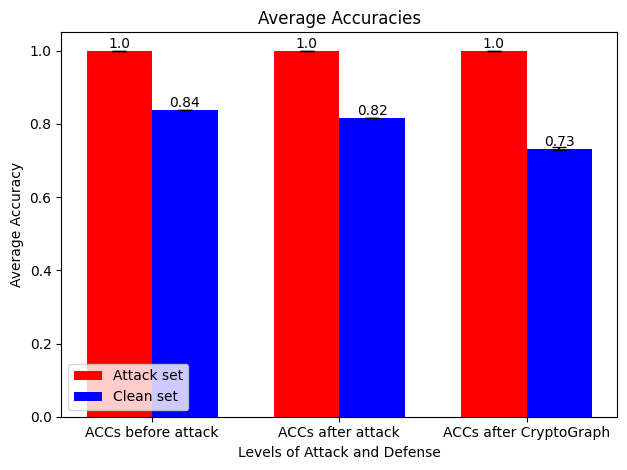

In [35]:
######## mahsa-V4.1: using surrogate model - edit 2 - using loss fonc and gradiant base- edge-score and commun neighbor ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually

import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import scipy.sparse as sp
import pickle

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function with respect to adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval() # sets the surrogate model to evaluation mode. In evaluation mode, certain layers (like dropout and batch normalization) behave differently compared to training mode.
    # Convert adjacency matrix to PyTorch tensor and enable gradient computation
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
     # Convert feature matrix and labels to PyTorch tensors
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    # Forward pass: compute model output (predictions) 
    output = surrogate_model(features, adj) 
    # Compute loss for the target node: how well the model's prediction matches the true label for the target_node
    loss = F.nll_loss(output[[target_node]], labels[[target_node]]) 
    #The backward pass computes the gradients of the loss. These gradients indicate how changes in the adjacency matrix would affect the loss.
    loss.backward()
    gradients = adj.grad.cpu().numpy()  # The gradients are extracted from the adjacency matrix tensor and converted to a NumPy array on the CPU.
    
    print(f"Loss for target node {target_node}: {loss.item()}")
    print(f"Gradients for target node {target_node}: {gradients}")
    # Check for non-zero gradients
    if not np.any(gradients):
        print(f"No non-zero gradients found for target node {target_node}.")
    else:
        non_zero_gradients = np.nonzero(gradients)
        print(f"Non-zero gradients for target node {target_node}:")
        for index in zip(*non_zero_gradients):
            print(f"Gradient at {index}: {gradients[index]}")

    return gradients


# Function to calculate edge scores based on gradients
# def calculate_edge_scores(adj, gradients, target_node, add=True):
#     scores = {}
#     for i in range(adj.shape[0]):
#         if add and adj[target_node, i] == 0:
#             scores[(target_node, i)] = gradients[target_node, i]  # if gradient is positive, it means that adding the edge would increase the loss
#         elif not add and adj[target_node, i] == 1:
#             scores[(target_node, i)] = -gradients[target_node, i] # if gradient is negative, it means that removing the edge would increase the loss
#     return scores # The scores (gradiants) are returned as a dictionary where the keys are the edges and the values are the gradients.

def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors) # The number of common neighbors between the two nodes is returned.

# Function to calculate edge scores based on gradients and common neighbors ...... it worked at least
def calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:  # Ensure different labels for adding
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:  # Ensure same labels for removing
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors 
    return scores



#it has problem, nothing is not added or removed
# def calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels):
#     add_scores = {}
#     remove_scores = {}
#     for i in range(adj.shape[0]):
#         # print(f"Common neighbors between {target_node} and {i}: number of neighbors:{len(common_neighbors)} and list is {common_neighbors}")
#         if adj[target_node, i] == 0 and labels[target_node] != labels[i]:  # if not neighbor and not same label : adding
#             common_neighbors = calculate_common_neighbors(adj, target_node, i)
#             add_scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
#             # print(f"Add score for edge ({target_node}, {i}): {add_scores[(target_node, i)]}")
#         elif adj[target_node, i] == 1 and labels[target_node] == labels[i]:  # if neighbor and  same label : removing
#             common_neighbors = calculate_common_neighbors(adj, target_node, i)
#             remove_scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors  # if gradient is negative, it means that removing the edge would increase the loss, so we put ne - to have a positive score to find the best edge to remove
#             # print(f"Remove score for edge ({target_node}, {i}): {remove_scores[(target_node, i)]}")
#     return add_scores, remove_scores


##### last version ----it worked at least but adds and removes.
def select_best_edge_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

#### it has problem, nothing is not added or removed
# def select_best_edge_common_neighbors(adj, gradients, target_node, labels):
#     add_scores, remove_scores = calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels)
#     if not add_scores and not remove_scores:
#         return None, None
#     best_add_edge = max(add_scores, key=add_scores.get) if add_scores else None
#     best_remove_edge = max(remove_scores, key=remove_scores.get) if remove_scores else None
    
#     best_add_score = add_scores[best_add_edge] if best_add_edge else float('-inf')
#     best_remove_score = remove_scores[best_remove_edge] if best_remove_edge else float('-inf')
#     if best_add_score > best_remove_score:
#         return best_add_edge, 'add'
#     else:
#         return best_remove_edge, 'remove'


################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    selected_node = 1196
    idx_test_attack = np.array([selected_node])
    idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    print(f"Selected node for attack: {selected_node}")
    print(f"Label of the selected node: {labels[selected_node]}")
    
    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    adj1 = sp.csr_matrix(adj1)
    adj2 = sp.csr_matrix(adj2)
    clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    neighbors_vector = adj1[selected_node, :].toarray()
    neighbors_indices = np.nonzero(neighbors_vector)[1]
    print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    modified_adj1 =  clean_adj1.copy()
    print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 10
    ############### attack adj ################
    attacked_adj = modified_adj1.copy()
    print(f"idx_test_attack: {idx_test_attack}")
    edges_added_count = 0
    edges_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        # neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        # neighbors_opposite_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        # print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        # print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposite_label)}")

        # Compute gradients and their signs
        gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        print(f"Gradients for target node {target_node}: {gradients}")
        
        ##### it shows that all the gradients are zero, so we can not use them for attack
        if not np.any(gradients):
            print(f"No non-zero gradients found for target node {target_node}. Skipping this node.")
            continue


        #### it works but it adds and removes
        for _ in range(budget):
            edge_add = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=False)
            print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                edges_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edges_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                
        #### it is not working, nothing is added or removed
        # for _ in range(budget):
        #         best_edge, action = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels)
        #         if not best_edge:
        #             continue

        #         if action == 'add':
        #             attacked_adj[best_edge[0], best_edge[1]] = 1
        #             attacked_adj[best_edge[1], best_edge[0]] = 1
        #             edges_added_count += 1
        #             print(f"Added edge: {best_edge}")

        #         elif action == 'remove':
        #             attacked_adj[best_edge[0], best_edge[1]] = 0
        #             attacked_adj[best_edge[1], best_edge[0]] = 0
        #             edges_removed_count += 1
        #             print(f"Removed edge: {best_edge}")

        print(f"Total number of added edges during attack: {edges_added_count}")
        print(f"Total number of removed edges during attack: {edges_removed_count}")





    ########## checking the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print (f"Number of edges added: {edges_added_count}")
    print (f"Number of edges removed: {edges_removed_count}")
    # print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    # changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    # print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj) by the CG: {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    removed_edges_by_CG = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges = []
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 0 and clean_adj1_array[i, j] == 1:
            removed_edges.append((i, j))
    print(f"Removed edges during attack: {removed_edges}")
    print(f"Total number of removed edges during attack: {len(removed_edges)}")


    # check if added edges are removed by CG defense
    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"added edges during attack which are removed by CG defense: {removed_edges_by_CG}")
    print(f"Total number of added edges during attack which are removed by CG defense: {len(removed_edges_by_CG)}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [4]:
#################### checkings if we have nodes with gradiants non zero losses non zero ... ################
####### choosing nodes for attack by selecting the nodes with non zero gradients and non zero losses ########
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import scipy.sparse as sp
import pickle


seed = 42  # Seed for reproducibility
num_repeats = 1

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function with respect to adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval() # sets the surrogate model to evaluation mode. In evaluation mode, certain layers (like dropout and batch normalization) behave differently compared to training mode.
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    # Forward pass: compute model output (predictions) 
    output = surrogate_model(features, adj) 
    # Compute loss for the target node: how well the model's prediction matches the true label for the target_node
    loss = F.nll_loss(output[[target_node]], labels[[target_node]]) 
    #The backward pass computes the gradients of the loss. These gradients indicate how changes in the adjacency matrix would affect the loss.
    loss.backward()
    gradients = adj.grad.cpu().numpy()  # The gradients are extracted from the adjacency matrix tensor and converted to a NumPy array on the CPU.
    
    # print(f"Loss for target node {target_node}: {loss.item()}")
    # print(f"Gradients for target node {target_node}: {gradients}")
    # Check for non-zero gradients
    # if not np.any(gradients):
    #     print(f"No non-zero gradients found for target node {target_node}.")
    # else:
    #     non_zero_gradients = np.nonzero(gradients)
    #     print(f"Non-zero gradients for target node {target_node}:")
    #     for index in zip(*non_zero_gradients):
    #         print(f"Gradient at {index}: {gradients[index]}")

    return  loss.item(), gradients


################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")

#performing the experiment for num_repeats times
for _ in range(num_repeats):
    set_seeds(seed)
    
    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

   
    ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

    # Calculate gradients and loss for each target node
    print(f"size of idx_test: {len(idx_test)}")
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0


    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)

       # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
        

        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        print(f"Loss for target node {target_node}: {loss}")
        print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
      
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
   
    print("Nodes with non-zero loss and non-zero gradients:")
    for node in non_zero_loss_and_gradients_nodes:
        print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)

    # Select top k nodes to attack
    k = 10  # Number of nodes to attack
    nodes_to_attack = [node for node, impact_score in non_zero_loss_and_gradients_nodes[:k]]
    print(f"Nodes to attack (node_id):")
    print(nodes_to_attack)

    print("Nodes to attack (node_id, impact_score):")
    for node, score in non_zero_loss_and_gradients_nodes[:k]:
        print(f"Node: {node}, Impact Score: {score}")



Loading polblogs dataset...
Number of training nodes: 40
Number of validation nodes: 500
Number of test nodes: 950
Test set results: loss= 0.3826 accuracy= 0.8389
size of idx_test: 950
Target node is: 1395 with label: 1
Loss for target node 1395: 0.0
Gradients for target node 1395: Zero
Target node is: 35 with label: 0
Loss for target node 35: 0.0
Gradients for target node 35: Zero
Target node is: 754 with label: 0
Loss for target node 754: 0.0
Gradients for target node 754: Zero
Target node is: 1169 with label: 1
Loss for target node 1169: 0.0
Gradients for target node 1169: Zero
Target node is: 362 with label: 0
Loss for target node 362: 0.0
Gradients for target node 362: Zero
Target node is: 1183 with label: 1
Loss for target node 1183: 0.0
Gradients for target node 1183: Non-zero
Target node is: 597 with label: 0
Loss for target node 597: 0.0
Gradients for target node 597: Zero
Target node is: 255 with label: 0
Loss for target node 255: 0.0
Gradients for target node 255: Zero
Targe

In [5]:
######## mahsa-V4.2: using surrogate model - using loss fonc and gradiant base- edge-score for choosing nodes to attack ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually

import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from experiments import split_dataset
from DistributedDefense import TwoPartyCNGCN
import networkx as nx
from scipy.sparse import csr_matrix
import mahsa_backdoor as backdoor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import scipy.sparse as sp
import pickle

# Define the number of repeats
num_repeats = 1
accuracy_test_attack_1_values = []
accuracy_test_clean_1_values = []
accuracy_test_attack_2_values = []
accuracy_test_clean_2_values = []
accuracy_test_attack_3_values = []
accuracy_test_clean_3_values = []

seed = 42  # Seed for reproducibility

# Function to set seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Function to train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                          nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Function to compute the gradients of the loss function with respect to adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval() # sets the surrogate model to evaluation mode. In evaluation mode, certain layers (like dropout and batch normalization) behave differently compared to training mode.
    # Convert adjacency matrix to PyTorch tensor and enable gradient computation
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
     # Convert feature matrix and labels to PyTorch tensors
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    # Forward pass: compute model output (predictions) 
    output = surrogate_model(features, adj) 
    # Compute loss for the target node: how well the model's prediction matches the true label for the target_node
    loss = F.nll_loss(output[[target_node]], labels[[target_node]]) 
    #The backward pass computes the gradients of the loss. These gradients indicate how changes in the adjacency matrix would affect the loss.
    loss.backward()
    gradients = adj.grad.cpu().numpy()  # The gradients are extracted from the adjacency matrix tensor and converted to a NumPy array on the CPU.
    
    # print(f"Loss for target node {target_node}: {loss.item()}")
    # print(f"Gradients for target node {target_node}: {gradients}")
    # # Check for non-zero gradients
    # if not np.any(gradients):
    #     print(f"No non-zero gradients found for target node {target_node}.")
    # else:
    #     non_zero_gradients = np.nonzero(gradients)
    #     print(f"Non-zero gradients for target node {target_node}:")
    #     for index in zip(*non_zero_gradients):
    #         print(f"Gradient at {index}: {gradients[index]}")

    return  loss.item(), gradients


def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors) # The number of common neighbors between the two nodes is returned.


def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)

        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)

    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
        

        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        print(f"Loss for target node {target_node}: {loss}")
        print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
    
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")

    print("Nodes with non-zero loss and non-zero gradients:")
    for node in non_zero_loss_and_gradients_nodes:
        print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)

    # Select top k nodes to attack
    k = 10  # Number of nodes to attack
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes[:k]]

    print("Nodes to attack (node_id, impact_score):")
    for node, score in non_zero_loss_and_gradients_nodes[:k]:
        print(f"Node: {node}, Impact Score: {score}")

    return nodes_to_attack


# Function to calculate edge scores based on gradients and common neighbors ...... it worked at least
def calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:  # Ensure different labels for adding
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:  # Ensure same labels for removing
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors 
    return scores

##### last version ----it worked at least but adds and removes.
def select_best_edge_common_neighbors(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores_common_neighbors(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge



################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

for _ in range(num_repeats):
    set_seeds(seed)
    adj, features, labels = data.adj, data.features, data.labels
    idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

    # selected_node = 1196
    # idx_test_attack = np.array([selected_node])
    # idx_test_clean = np.array([node for node in idx_test if node != selected_node])
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    
    ################### split idx_test into two parts : one node for attack randomley and the rest for clean
    # test_size = 1  # 1 node for attack others for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=42)
    # selected_node = idx_test_attack[0]
    # print(f"Selected node for attack: {selected_node}")
    # print(f"Label of the selected node: {labels[selected_node]}")
    ################ split idx_test into two parts randomly with a specific ratio %
    # test_size = 0.10  # 10% for test_attack, 90% for test_clean
    # idx_test_clean , idx_test_attack = train_test_split(idx_test, test_size=test_size, random_state=seed)
    ######################



     ######## train surrogate model to find the importance of each edge
    surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)


    ################ split idx_test into two parts for attack: nodes_for_attack and the rest for clean
    # Assuming nodes_to_attack is a function that returns the nodes to attack
    idx_test_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
    nodes_to_attack_set = set(idx_test_attack)
    idx_test_clean = [node for node in idx_test if node not in nodes_to_attack_set]
    print(f"Nodes to attack: {idx_test_attack}, len= {len(idx_test_attack)}")
    print(f"Nodes for clean: {idx_test_clean}, len= {len(idx_test_clean)}")

    ######################

    proportion_of_common_links = 0.5
    adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

    # adj1 = sp.csr_matrix(adj1)
    # adj2 = sp.csr_matrix(adj2)
    # clean_adj1 = backdoor.remove_zero_weight_edges(adj1.copy())
    # clean_adj2 = backdoor.remove_zero_weight_edges(adj2.copy())
    
    # neighbors_vector = adj1[selected_node, :].toarray()
    # neighbors_indices = np.nonzero(neighbors_vector)[1]
    # print(f"num of neighbors of node {selected_node} is: {len(neighbors_indices)}")
    # print("Neighbors of node", selected_node, "are:", neighbors_indices)

    ###### Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.test(idx_test)

    accuracy_test_attack_1 = model.test(idx_test_attack) 
    accuracy_test_clean_1 = model.test(idx_test_clean)
    print("Test accuracy on attack set: ", accuracy_test_attack_1)
    print("Test accuracy on clean set: ", accuracy_test_clean_1)

   
   
    # modified_adj1 =  clean_adj1.copy()
    # print(f"Initial number of edges: {modified_adj1.nnz // 2}")
    # print(f"Number of nodes: {modified_adj1.shape[0]}")

    budget = 5
    ############### attack adj ################
    attacked_adj = adj1.copy()
    print(f"idx_test_attack: {idx_test_attack}")
    edges_added_count = 0
    edges_removed_count = 0

    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        # neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)
        # neighbors_opposite_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)
        # print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")
        # print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposite_label)}")

        # Compute gradients and their signs
        gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        print(f"Gradients for target node {target_node}: {gradients}")
        
        ##### it shows that all the gradients are zero, so we can not use them for attack
        if not np.any(gradients):
            print(f"No non-zero gradients found for target node {target_node}. Skipping this node.")
            continue


        #### it works but it adds and removes
        for _ in range(budget):
            edge_add = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels, add=False)
            print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                edges_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edges_removed_count += 1
                print(f"Removed edge: {edge_remove}")
                
        #### it is not working, nothing is added or removed
        # for _ in range(budget):
        #         best_edge, action = select_best_edge_common_neighbors(attacked_adj, gradients, target_node, labels)
        #         if not best_edge:
        #             continue

        #         if action == 'add':
        #             attacked_adj[best_edge[0], best_edge[1]] = 1
        #             attacked_adj[best_edge[1], best_edge[0]] = 1
        #             edges_added_count += 1
        #             print(f"Added edge: {best_edge}")

        #         elif action == 'remove':
        #             attacked_adj[best_edge[0], best_edge[1]] = 0
        #             attacked_adj[best_edge[1], best_edge[0]] = 0
        #             edges_removed_count += 1
        #             print(f"Removed edge: {best_edge}")

        print(f"Total number of added edges during attack: {edges_added_count}")
        print(f"Total number of removed edges during attack: {edges_removed_count}")





    ########## checking the adj wise changes after attack ##########
    modified_adj1 = csr_matrix(attacked_adj)
    print (f"Number of edges added: {edges_added_count}")
    print (f"Number of edges removed: {edges_removed_count}")
    # print(modified_adj1)

    # check for the differences between the initial graph and the attacked graph
    diff_adj_attack = modified_adj1 - clean_adj1
    non_zero_diff = diff_adj_attack.nonzero()
    print(f"adj wise : modifications after attack: {non_zero_diff}")
    num_changes = len(non_zero_diff[0]) // 2
    print(f"adj wise: Number of modifications after attack: {num_changes}")

    # evaluation after attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, modified_adj1, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()

    accuracy_test_attack_2 = model.test(idx_test_attack) 
    accuracy_test_clean_2 = model.test(idx_test_clean)

    print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
    print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

    ################# Crypto'Graph defense ####################3
    print("*************** Crypto'Graph defense ***************")

    threshold = 2
    metric = "neighbors"
    object = "links"
    model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1,
                          device=device)
    defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        modified_adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
    model.eval()
    accuracies = model.test(idx_test)
    accuracy_test_attack_3 = model.test(idx_test_attack)
    accuracy_test_clean_3 = model.test(idx_test_clean)
    print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
    print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

    rows = CG_defended_adj1.shape[0]
    print(f"CG_defended_adj1. Number of rows: {rows}")

    print("*************** adj wise compare (before and after defense) ***************")
    differences = np.abs(CG_defended_adj1 - modified_adj1)
    total_differences = np.sum(differences)
    print(f"adj check: Total number of differences: {total_differences}")
    rows_with_changes = np.count_nonzero(np.sum(differences, axis=1))
    print(f"Number of rows with changes: {rows_with_changes}")
    # changed_rows = np.where(np.sum(differences, axis=1) > 0)[0]
    # print(f"Rows with different connectivities: {changed_rows}")

    difference_matrix = CG_defended_adj1 - modified_adj1
    rows, cols = np.triu_indices_from(difference_matrix, k=1)
    upper_triangle_differences = difference_matrix[rows, cols]
    removed_edges = np.argwhere(upper_triangle_differences < 0)
    total_removed_edges = len(removed_edges)
    print(f"Total number of removed edges(adj) by the CG: {total_removed_edges}")

    # Identify the edges added during the attack and check if they are removed by CG defense
    added_edges = []
    removed_edges_by_CG = []
    modified_adj1_array = modified_adj1.toarray()
    clean_adj1_array = clean_adj1.toarray()

    rows, cols = np.triu_indices(modified_adj1_array.shape[0], k=1)
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 1 and clean_adj1_array[i, j] == 0:
            added_edges.append((i, j))
    print(f"Added edges during attack: {added_edges}")
    print(f"Total number of added edges during attack: {len(added_edges)}")

    removed_edges = []
    for i, j in zip(rows, cols):
        if modified_adj1_array[i, j] == 0 and clean_adj1_array[i, j] == 1:
            removed_edges.append((i, j))
    print(f"Removed edges during attack: {removed_edges}")
    print(f"Total number of removed edges during attack: {len(removed_edges)}")


    # check if added edges are removed by CG defense
    for edge in added_edges:
        i, j = edge
        if CG_defended_adj1_array[i, j] == 0:
            removed_edges_by_CG.append(edge)
    print(f"added edges during attack which are removed by CG defense: {removed_edges_by_CG}")
    print(f"Total number of added edges during attack which are removed by CG defense: {len(removed_edges_by_CG)}")

    accuracy_test_attack_1_values.append(accuracy_test_attack_1)
    accuracy_test_clean_1_values.append(accuracy_test_clean_1)
    accuracy_test_attack_2_values.append(accuracy_test_attack_2)
    accuracy_test_clean_2_values.append(accuracy_test_clean_2)
    accuracy_test_attack_3_values.append(accuracy_test_attack_3)
    accuracy_test_clean_3_values.append(accuracy_test_clean_3)

accuracy_test_attack_1_std = np.std(accuracy_test_attack_1_values)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1_values)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2_values)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2_values)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3_values)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3_values)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1_values)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1_values)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2_values)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2_values)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3_values)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3_values)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


Loading polblogs dataset...
Target node is: 1395 with label: 1
Loss for target node 1395: 0.0
Gradients for target node 1395: Zero
Target node is: 35 with label: 0
Loss for target node 35: 0.0
Gradients for target node 35: Zero
Target node is: 754 with label: 0
Loss for target node 754: 0.0
Gradients for target node 754: Zero
Target node is: 1169 with label: 1
Loss for target node 1169: 0.0
Gradients for target node 1169: Zero
Target node is: 362 with label: 0
Loss for target node 362: 0.0
Gradients for target node 362: Zero
Target node is: 1183 with label: 1
Loss for target node 1183: 0.0
Gradients for target node 1183: Non-zero
Target node is: 597 with label: 0
Loss for target node 597: 0.0
Gradients for target node 597: Zero
Target node is: 255 with label: 0
Loss for target node 255: 0.0
Gradients for target node 255: Zero
Target node is: 1036 with label: 1
Loss for target node 1036: 0.0
Gradients for target node 1036: Zero
Target node is: 1008 with label: 1
Loss for target node 100

'\n    budget = 10\n    ############### attack adj ################\n    attacked_adj = modified_adj1.copy()\n    print(f"idx_test_attack: {idx_test_attack}")\n    edges_added_count = 0\n    edges_removed_count = 0\n\n    for target_node in idx_test_attack:\n        print(f"Target node is: {target_node} with label: {labels[target_node]}")\n        # neighbors_same_label = backdoor.find_same_neighbor_adj(attacked_adj, labels, target_node)\n        # neighbors_opposite_label = backdoor.find_opposite_neighbor_adj(attacked_adj, labels, target_node)\n        # print(f"Number of target same label neighbors before attack: {len(neighbors_same_label)}")\n        # print(f"Number of target opposite label neighbors before attack: {len(neighbors_opposite_label)}")\n\n        # Compute gradients and their signs\n        gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)\n        print(f"Gradients for target node {target_node}: {gradients}")\n        \n      

In [5]:
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        print(f"Loss for target node {target_node}: {loss}")
        print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
    
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")

    print("Nodes with non-zero loss and non-zero gradients:")
    for node in non_zero_loss_and_gradients_nodes:
        print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # Select top k nodes to attack
    # k = 10  # Number of nodes to attack
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes[:k]]
    # print("Nodes to attack (node_id, impact_score):")
    # for node, score in non_zero_loss_and_gradients_nodes[:k]:
    #     print(f"Node: {node}, Impact Score: {score}")
    return nodes_to_attack

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget):
    attacked_adj = adj.copy()
    for target_node in idx_test_attack:
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False)
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
    return attacked_adj

# Main execution
set_seeds(42)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Determine nodes to attack
k = 10
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]

# Initial model evaluation
model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

# Initial accuracy
accuracy_test_attack_1 = model.test(idx_test_attack)
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Initial test accuracy on attack set: ", accuracy_test_attack_1)
print("Initial test accuracy on clean set: ", accuracy_test_clean_1)
print("start attacking")

# Perturb edges
budget = 5
attacked_adj = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

# Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links)
model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
model.fit(adj1, adj2, features, features, labels, idx_train, threshold=2, metric="neighbors", object="links", train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Save and plot results
with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1, accuracy_test_clean_1, accuracy_test_attack_2, accuracy_test_clean_2, accuracy_test_attack_3, accuracy_test_clean_3], f)

# Ensure values and std_devs are properly formatted as floats
values = [float(accuracy_test_attack_1), float(accuracy_test_clean_1),
          float(accuracy_test_attack_2), float(accuracy_test_clean_2),
          float(accuracy_test_attack_3), float(accuracy_test_clean_3)]

# Assuming std_devs were previously calculated and are available in the same format
std_devs = [np.std([accuracy_test_attack_1]), np.std([accuracy_test_clean_1]),
            np.std([accuracy_test_attack_2]), np.std([accuracy_test_clean_2]),
            np.std([accuracy_test_attack_3]), np.std([accuracy_test_clean_3])]

labels = ['Initial Attack', 'Initial Clean', 'After Attack', 'After Clean', 'After CryptoGraph', 'After CryptoGraph']

x = np.arange(len(labels) // 2)
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width / 2, values[::2], width, label='Attack Set', color='red', capsize=5)
bars2 = ax.bar(x + width / 2, values[1::2], width, label='Clean Set', color='blue', capsize=5)

ax.set_xlabel('Stages')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy at Different Stages')
ax.set_xticks(x)
ax.set_xticklabels(labels[::2])
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Loading polblogs dataset...
Target node is: 1395 with label: 1
Loss for target node 1395: 0.0
Gradients for target node 1395: Zero
Target node is: 35 with label: 0
Loss for target node 35: 0.0
Gradients for target node 35: Zero
Target node is: 754 with label: 0
Loss for target node 754: 0.0
Gradients for target node 754: Zero
Target node is: 1169 with label: 1
Loss for target node 1169: 0.0
Gradients for target node 1169: Zero
Target node is: 362 with label: 0
Loss for target node 362: 0.0
Gradients for target node 362: Zero
Target node is: 1183 with label: 1
Loss for target node 1183: 0.0
Gradients for target node 1183: Non-zero
Target node is: 597 with label: 0
Loss for target node 597: 0.0
Gradients for target node 597: Zero
Target node is: 255 with label: 0
Loss for target node 255: 0.0
Gradients for target node 255: Zero
Target node is: 1036 with label: 1
Loss for target node 1036: 0.0
Gradients for target node 1036: Zero
Target node is: 1008 with label: 1
Loss for target node 100

TypeError: float() argument must be a string or a number, not 'tuple'

Loading polblogs dataset...
Final number of nodes with zero loss: 737
Final number of nodes with zero gradients: 690
Final number of nodes with zero loss but non-zero gradients: 47
Number of nodes with non-zero loss and non-zero gradients: 213
Test set results: loss= 0.3643 accuracy= 0.8547
Test set results: loss= 1.5997 accuracy= 0.1000
Test set results: loss= 0.3511 accuracy= 0.8628
Test accuracy on attack set:  0.1
Test accuracy on clean set:  0.8627659574468085
Target node is: 1130 with label: 1


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1130, 362)
Removed edge: (1130, 1228)
Target node is: 275 with label: 0
Added edge: (275, 1100)
Removed edge: (275, 695)
Target node is: 118 with label: 0
Added edge: (118, 854)
Removed edge: (118, 311)
Target node is: 489 with label: 0
Added edge: (489, 854)
Removed edge: (489, 418)
Target node is: 808 with label: 1
Added edge: (808, 54)
Removed edge: (808, 1178)
Target node is: 1228 with label: 1
Added edge: (1228, 54)
Target node is: 1116 with label: 1
Added edge: (1116, 728)
Removed edge: (1116, 931)
Target node is: 1476 with label: 1
Added edge: (1476, 154)
Target node is: 1108 with label: 1
Added edge: (1108, 154)
Removed edge: (1108, 935)
Target node is: 499 with label: 0
Added edge: (499, 854)
Removed edge: (499, 538)
Test set results: loss= 1.5332 accuracy= 0.1000
Test set results: loss= 0.3744 accuracy= 0.8553
Test accuracy on attack set after attack:  0.1
Test accuracy on clean set after attack:  0.8553191489361702
*************** Crypto'Graph defense **********

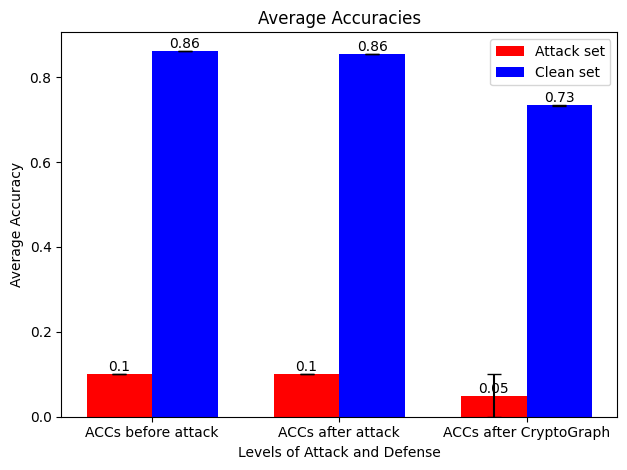

In [15]:
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle



# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
        # print(f"Target node is: {target_node} with label: {labels[target_node]}")
        # print(f"Loss for target node {target_node}: {loss}")
        # print(f"Gradients for target node {target_node}: {'Non-zero' if not zero_gradients else 'Zero'}")
    
    # Print the counts of nodes with zero loss and zero gradients
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")

    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]

    # Select top k nodes to attack
    # k = 10  # Number of nodes to attack
    # nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes[:k]]
    # print("Nodes to attack (node_id, impact_score):")
    # for node, score in non_zero_loss_and_gradients_nodes[:k]:
    #     print(f"Node: {node}, Impact Score: {score}")
    return nodes_to_attack

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, add)
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget):
    attacked_adj = adj.copy()
    edge_added_count = 0
    edge_removed_count = 0
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False)
            # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
    return attacked_adj

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 10  # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]

########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 1  # Number of edges to add or remove for each target node
attacked_adj = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
roportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links) 
threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)




################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()








Loading polblogs dataset...
Final number of nodes with zero loss: 737
Final number of nodes with zero gradients: 690
Final number of nodes with zero loss but non-zero gradients: 47
Number of nodes with non-zero loss and non-zero gradients: 213
Test set results: loss= 0.3643 accuracy= 0.8547
Test set results: loss= 1.5997 accuracy= 0.1000
Test set results: loss= 0.3511 accuracy= 0.8628
Test accuracy on attack set:  0.1
Test accuracy on clean set:  0.8627659574468085
Target node is: 1130 with label: 1
Added edge: (1130, 362)
Removed edge: (1130, 1228)
Target node is: 275 with label: 0


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (275, 1100)
Removed edge: (275, 695)
Target node is: 118 with label: 0
Added edge: (118, 854)
Removed edge: (118, 311)
Target node is: 489 with label: 0
Added edge: (489, 854)
Removed edge: (489, 418)
Target node is: 808 with label: 1
Added edge: (808, 54)
Removed edge: (808, 1178)
Target node is: 1228 with label: 1
Added edge: (1228, 54)
Target node is: 1116 with label: 1
Added edge: (1116, 728)
Removed edge: (1116, 931)
Target node is: 1476 with label: 1
Added edge: (1476, 154)
Target node is: 1108 with label: 1
Added edge: (1108, 154)
Removed edge: (1108, 935)
Target node is: 499 with label: 0
Added edge: (499, 854)
Removed edge: (499, 538)
Total number of edges added: 10
Total number of edges removed: 8
Test set results: loss= 1.5332 accuracy= 0.1000
Test set results: loss= 0.3744 accuracy= 0.8553
Test accuracy on attack set after attack:  0.1
Test accuracy on clean set after attack:  0.8553191489361702
*************** Crypto'Graph defense ***************
Dropping dissi

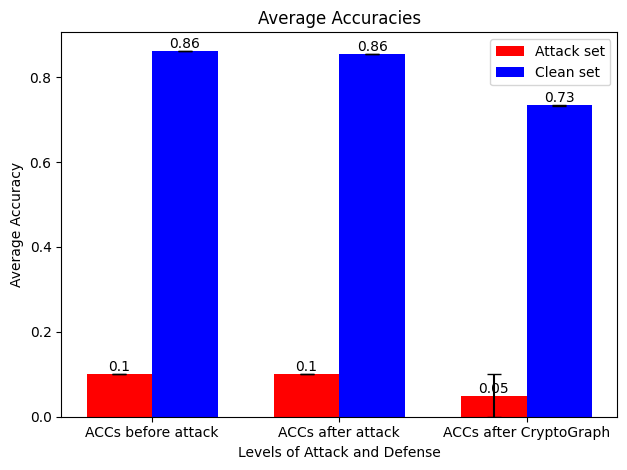

In [25]:
######## mahsa-V4.2: using surrogate model - using loss fonc and gradiant base- edge-score for choosing nodes to attack ################
# attack adding/removing edge: (le budget adaptatif pour ajouter/enlever) ###############
# surrogat model for each edge to be added or removed, target nodes selected manually
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test):
    zero_loss_count = 0
    zero_gradients_count = 0
    non_zero_loss_and_gradients_nodes = []
    zero_loss_non_ziro_gr = 0

    for target_node in idx_test:
        loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
        if loss == 0:
            zero_loss_count += 1
        if not np.any(gradients):
            zero_gradients_count += 1
        
        zero_loss = loss == 0
        zero_gradients = not np.any(gradients)
    # If both loss and gradients are non-zero, store the node
        if not zero_loss and not zero_gradients:
            impact_score = loss * np.sum(np.abs(gradients))
            non_zero_loss_and_gradients_nodes.append((target_node, impact_score))
        # Ensure consistency between zero loss and zero gradients
        if zero_loss and not zero_gradients:
            # print(f"Warning: Target node {target_node} has zero loss but non-zero gradients!")
            zero_loss_non_ziro_gr += 1
    
    print(f"Final number of nodes with zero loss: {zero_loss_count}")
    print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
    print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
    # print("Nodes with non-zero loss and non-zero gradients:")
    # for node in non_zero_loss_and_gradients_nodes:
    #     print(node)
    print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")
    # Sort nodes by impact score in descending order
    non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
    nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
    return nodes_to_attack


####### new strategy of adding alpha beta to the impact score to consider the common neighbors while selecting nodes to attack
####### not have good results all 0.1 accuracies.
# def calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test, alpha=1.0, beta=1.0):
#     zero_loss_count = 0
#     zero_gradients_count = 0
#     non_zero_loss_and_gradients_nodes = []
#     zero_loss_non_ziro_gr = 0

#     for target_node in idx_test:
#         loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
#         if loss == 0:
#             zero_loss_count += 1
#         if not np.any(gradients):
#             zero_gradients_count += 1
        
#         zero_loss = loss == 0
#         zero_gradients = not np.any(gradients)
#         if not zero_loss and not zero_gradients:
#             impact_score = loss * np.sum(np.abs(gradients))
#             common_neighbors = sum(calculate_common_neighbors(adj, target_node, i) for i in range(adj.shape[0]) if i != target_node)
#             final_score = alpha * impact_score + beta * common_neighbors
#             non_zero_loss_and_gradients_nodes.append((target_node, final_score))
        
#         if zero_loss and not zero_gradients:
#             zero_loss_non_ziro_gr += 1
    
#     print(f"Final number of nodes with zero loss: {zero_loss_count}")
#     print(f"Final number of nodes with zero gradients: {zero_gradients_count}")
#     print(f"Final number of nodes with zero loss but non-zero gradients: {zero_loss_non_ziro_gr}")
#     print(f"Number of nodes with non-zero loss and non-zero gradients: {len(non_zero_loss_and_gradients_nodes)}")

#     # Sort nodes by the final score in descending order
#     non_zero_loss_and_gradients_nodes.sort(key=lambda x: x[1], reverse=True)
#     nodes_to_attack = [node for node, score in non_zero_loss_and_gradients_nodes]
#     return nodes_to_attack



# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores based on gradients and common neighbors
def calculate_edge_scores(adj, gradients, target_node, labels, add=True):
    scores = {}
    for i in range(adj.shape[0]):
        if add and adj[target_node, i] == 0 and labels[target_node] != labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = gradients[target_node, i] + common_neighbors #* 10  # 10 is a hyperparameter, can be tuned
        elif not add and adj[target_node, i] == 1 and labels[target_node] == labels[i]:
            common_neighbors = calculate_common_neighbors(adj, target_node, i)
            scores[(target_node, i)] = -gradients[target_node, i] + common_neighbors #* 10 # 10 is a hyperparameter
    return scores

# Select best edge based on edge scores
def select_best_edge(adj, gradients, target_node, labels, add=True):
    scores = calculate_edge_scores(adj, gradients, target_node, labels, add) ########################################just add?
    if not scores:
        return None
    if add:
        best_edge = max(scores, key=scores.get)
    else:
        best_edge = min(scores, key=scores.get)
    return best_edge

# Perturb edges between target nodes
def perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget):
    attacked_adj = adj.copy()
    added_edges = []  # Track added edges
    edge_added_count = 0
    edge_removed_count = 0
    for target_node in idx_test_attack:
        print(f"Target node is: {target_node} with label: {labels[target_node]}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)
        if not np.any(gradients):
            continue
        for _ in range(budget):
            edge_add = select_best_edge(attacked_adj, gradients, target_node, labels, add=True)
            edge_remove = select_best_edge(attacked_adj, gradients, target_node, labels, add=False)
            # print(f"edge_add: {edge_add}, edge_remove: {edge_remove}")
            if edge_add:
                attacked_adj[edge_add[0], edge_add[1]] = 1
                attacked_adj[edge_add[1], edge_add[0]] = 1
                added_edges.append(edge_add)  # Track added edge
                edge_added_count += 1
                print(f"Added edge: {edge_add}")
            if edge_remove:
                attacked_adj[edge_remove[0], edge_remove[1]] = 0
                attacked_adj[edge_remove[1], edge_remove[0]] = 0
                edge_removed_count += 1
                print(f"Removed edge: {edge_remove}")
    print(f"Total number of edges added: {edge_added_count}") 
    print(f"Total number of edges removed: {edge_removed_count}")      
    return attacked_adj, added_edges  # Return added edges for tracking

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42
 
set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test


############  Train surrogate model and determine nodes to attack
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

k = 10  # budget in the meaning of Number of nodes to attack
nodes_to_attack = calc_nodes_to_attack(surrogate_model, features, adj, labels, idx_test)
idx_test_attack = nodes_to_attack[:k]
idx_test_clean = [node for node in idx_test if node not in idx_test_attack]

########### Train GCN model initially for evaluation before attack
model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
            nhid=16, device=device, dropout=0.5)
model = model.to(device)
model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()
output = model.test(idx_test)

accuracy_test_attack_1 = model.test(idx_test_attack) 
accuracy_test_clean_1 = model.test(idx_test_clean)
print("Test accuracy on attack set: ", accuracy_test_attack_1)
print("Test accuracy on clean set: ", accuracy_test_clean_1)

############# perform attack Perturb edges
budget = 1  # Number of edges to add or remove for each target node
attacked_adj, added_edges = perturb_edges_between_targets(adj, surrogate_model, features, labels, idx_test_attack, budget)

# Model evaluation after attack
model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
model.eval()

accuracy_test_attack_2 = model.test(idx_test_attack)
accuracy_test_clean_2 = model.test(idx_test_clean)
print("Test accuracy on attack set after attack: ", accuracy_test_attack_2)
print("Test accuracy on clean set after attack: ", accuracy_test_clean_2)

##################   Crypto'Graph defense
print("*************** Crypto'Graph defense ***************")
proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(attacked_adj, proportion_of_common_links) 
threshold = 2
metric = "neighbors"
object = "links"

model = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
defense_duration, defense_duration, training_duration1, training_duration2, CG_defended_adj1, CG_defended_adj2 = model.fit(
        adj1.copy(), adj2.copy(), features, features, labels, idx_train, threshold, metric=metric, object=object,
        train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
model.eval()

accuracy_test_attack_3 = model.test(idx_test_attack)
accuracy_test_clean_3 = model.test(idx_test_clean)
print("Test accuracy on attack set after Crypto'Graph: ", accuracy_test_attack_3)
print("Test accuracy on clean set after Crypto'Graph: ", accuracy_test_clean_3)

# Function to find removed edges
def find_removed_edges(original_adj, defended_adj1, defended_adj2):
    removed_edges = []
    original_adj = original_adj.toarray()
    defended_adj1 = defended_adj1.toarray()
    defended_adj2 = defended_adj2.toarray()
    combined_defended_adj = np.maximum(defended_adj1, defended_adj2)
    for i in range(original_adj.shape[0]):
        for j in range(i + 1, original_adj.shape[1]):
            if original_adj[i, j] == 1 and combined_defended_adj[i, j] == 0:
                removed_edges.append((i, j))
    return removed_edges

# Find all removed edges
removed_edges = find_removed_edges(attacked_adj, CG_defended_adj1, CG_defended_adj2)
print(f"Total number of removed edges by CG: {len(removed_edges)}")

# Check if any of the inserted edges during the attack were removed by CG
removed_inserted_edges = [edge for edge in added_edges if edge in removed_edges]
print(f"Inserted edges removed by CG: {removed_inserted_edges}")
print(f"Number of inserted edges removed by CG: {len(removed_inserted_edges)}")

################ Save and plot results
accuracy_test_attack_1_std = np.std(accuracy_test_attack_1)
accuracy_test_clean_1_std = np.std(accuracy_test_clean_1)
accuracy_test_attack_2_std = np.std(accuracy_test_attack_2)
accuracy_test_clean_2_std = np.std(accuracy_test_clean_2)
accuracy_test_attack_3_std = np.std(accuracy_test_attack_3)
accuracy_test_clean_3_std = np.std(accuracy_test_clean_3)

with open('variables_std.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
                 accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
                 accuracy_test_attack_3_std, accuracy_test_clean_3_std], f)

accuracy_test_attack_1_avg = np.mean(accuracy_test_attack_1)
accuracy_test_clean_1_avg = np.mean(accuracy_test_clean_1)
accuracy_test_attack_2_avg = np.mean(accuracy_test_attack_2)
accuracy_test_clean_2_avg = np.mean(accuracy_test_clean_2)
accuracy_test_attack_3_avg = np.mean(accuracy_test_attack_3)
accuracy_test_clean_3_avg = np.mean(accuracy_test_clean_3)

with open('variables.pkl', 'wb') as f:
    pickle.dump([accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
                 accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
                 accuracy_test_attack_3_avg, accuracy_test_clean_3_avg], f)

labels = ['ACCs before attack', 'ACCs before attack', 
          'ACCs after attack', 'ACCs after attack', 
          'ACCs after CryptoGraph', 'ACCs after CryptoGraph']
values = [accuracy_test_attack_1_avg, accuracy_test_clean_1_avg, 
          accuracy_test_attack_2_avg, accuracy_test_clean_2_avg, 
          accuracy_test_attack_3_avg, accuracy_test_clean_3_avg]
std_devs = [accuracy_test_attack_1_std, accuracy_test_clean_1_std, 
            accuracy_test_attack_2_std, accuracy_test_clean_2_std, 
            accuracy_test_attack_3_std, accuracy_test_clean_3_std]
x = np.arange(len(labels)//2)
width = 0.35
bars1 = plt.bar(x - width/2, values[::2], width, yerr=std_devs[::2], label='Attack set', color='red', capsize=5)
bars2 = plt.bar(x + width/2, values[1::2], width, yerr=std_devs[1::2], label='Clean set', color='blue', capsize=5)
plt.title('Average Accuracies')
plt.xlabel('Levels of Attack and Defense')
plt.ylabel('Average Accuracy')
plt.xticks(x, labels[::2])
plt.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
plt.tight_layout()
plt.show()


1. inke az argmax estefade kone dorost baraye probability inke che tasiri mizare bego boro maghalehaye nettack o ... ro bekhon tebghe ona

3. when model fooled, even if budget is still remaining, stop the process
in a defined budget if att successful ok. if needed more bud, tell prompt


8. version v4.1 ham alan dorost kar nemikone, chon ke hichi na add mikone na remove, fek konam moshkel ine ke vaghti mikhad entekhab kone add kone ya remove hichi mishe. to noskhe ghabli ke ham add mikard ham remove joda joda ok bod anjam mishod vaghean. vali alan aziat mikone,
hala switch konim roye v4.2 behtare vaght bezarim

9. faghat add????? be shomare 8 bargard bebin chi mishe. alan ba ye budget ham add ham remove mikone
10. ba formule jadid common neighbor dar entekhab node ha ham barresi kon chera az 0.1 abla pain nemire, tedad o budgethaye mokhtalef
11. maybe change alpha beta in new impact score for node selection
maybe change node selection 
12. have some results table